In [1]:
from analysis import *
import math

from astropy.io import fits

In [2]:
def plot_PSD_w_slope(time, flux, ax,l='', **kwargs):
    """
    Plot some stuff (TODO: comment this function later)
    **kwargs is plotting the PSD
    """
    f,power = LS_PSD(time*86400,flux, f=k2_freq)

    # calculate PSD slopes
    freq_corr, power_corr = LS_PSD(time*86400, flux, f = k2_freq)

    noise_floor_days = 5
    # noise floor are freqencies > X days, convert to Hz
    noise_floor_mask = freq_corr>(2*np.pi/(noise_floor_days*86400))

    m, b = np.polyfit(np.log10(freq_corr)[~noise_floor_mask], np.log10(power_corr)[~noise_floor_mask], 1)
    m_noise, b_noise = np.polyfit(np.log10(freq_corr)[noise_floor_mask], np.log10(power_corr)[noise_floor_mask], 1)


    ax.plot(f,power, label=l+" PSD", **kwargs)
    ax.plot(freq_corr[~noise_floor_mask], 10**(np.log10(freq_corr[~noise_floor_mask])*m+b), 
                 label="fit above noise floor m = %.2f"%m, linewidth=3, alpha = 1)
    ax.plot(freq_corr[noise_floor_mask], 10**(np.log10(freq_corr[noise_floor_mask])*m_noise+b_noise), 
                 label="fit below noise floor m = %.2f"%m_noise, linewidth=3, alpha = 1)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("frequency [Hz]")
    ax.set_ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")

In [27]:
bad_epics = [220176138, 220170097, 220176624, 220179771]

In [7]:
# run everest detrended
lc_eve = everest.Everest(bad_epics[0], season=8)

# turning indices found to be "bad" into a boolen mask to apply
cad = np.arange(len(lc_eve.flux))# put flux/cadences into an array
mask = (np.isin(cad, np.concatenate([lc_eve.nanmask, lc_eve.badmask, lc_eve.mask]))) # get the m ask for "bad" cadences

INFO  [everest.user.DownloadFile()]: Downloading the file...
INFO  [everest.user.load_fits()]: Loading FITS file for 220192831.


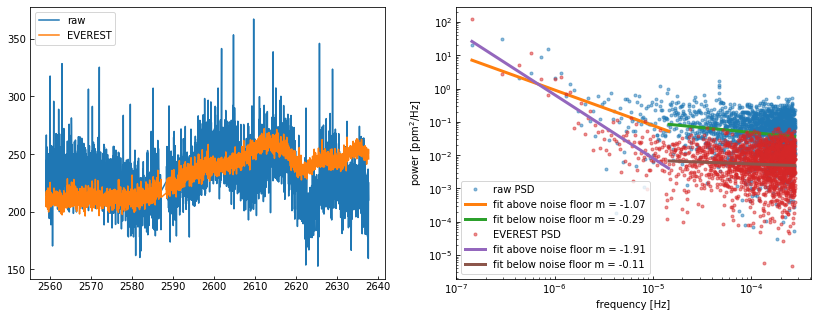

In [8]:
# plot it 
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(lc_eve.time[~mask], lc_eve.fraw[~mask], label="raw")
plot_PSD_w_slope(lc_eve.time[~mask], lc_eve.fraw[~mask], ax[1], l='raw', marker='.', ls='', alpha=0.5)

ax[0].plot(lc_eve.time[~mask], lc_eve.flux[~mask], label="EVEREST")
plot_PSD_w_slope(lc_eve.time[~mask], lc_eve.flux[~mask], ax[1], l='EVEREST', marker='.', ls='', alpha=0.5)

ax[0].legend()

In [11]:
%%time
print("Kernel params before",lc_eve.kernel_params)

# turn off the kernel
lc_eve.kernel_params[1] = 0.0#red noise amp 

#Matern3/2 timescale
#making it really tiny allows us to see if the kernal is adding varibility on short timescales
#lc_eve.kernel_params[2] = .0001 # days

lc_eve.compute()

Kernel params before [4.20393451e-01 0.00000000e+00 1.00000000e-04]
INFO  [everest.basecamp.compute()]: Computing the model...
CPU times: user 13.9 s, sys: 1.34 s, total: 15.2 s
Wall time: 6.13 s


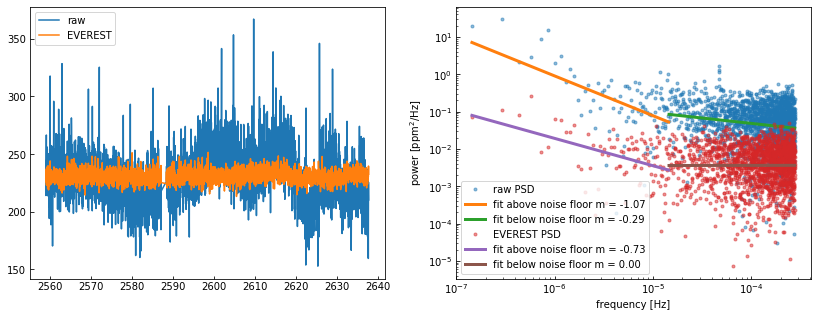

In [12]:
# plot it 
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(lc_eve.time[~mask], lc_eve.fraw[~mask], label="raw")
plot_PSD_w_slope(lc_eve.time[~mask], lc_eve.fraw[~mask], ax[1], l='raw', marker='.', ls='', alpha=0.5)

ax[0].plot(lc_eve.time[~mask], lc_eve.flux[~mask], label="EVEREST w/o kernel")
plot_PSD_w_slope(lc_eve.time[~mask], lc_eve.flux[~mask], ax[1], l='EVEREST w/o kernel', marker='.', ls='', alpha=0.5)

ax[0].legend()

---
loop and do it for these objects quickly

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220176138.
INFO  [everest.basecamp.compute()]: Computing the model...
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220170097.
INFO  [everest.basecamp.compute()]: Computing the model...
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220176624.
INFO  [everest.basecamp.compute()]: Computing the model...
INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220179771.
INFO  [everest.basecamp.compute()]: Computing the model...
CPU times: user 1min 6s, sys: 6.51 s, total: 1min 13s
Wall time: 29.6 s


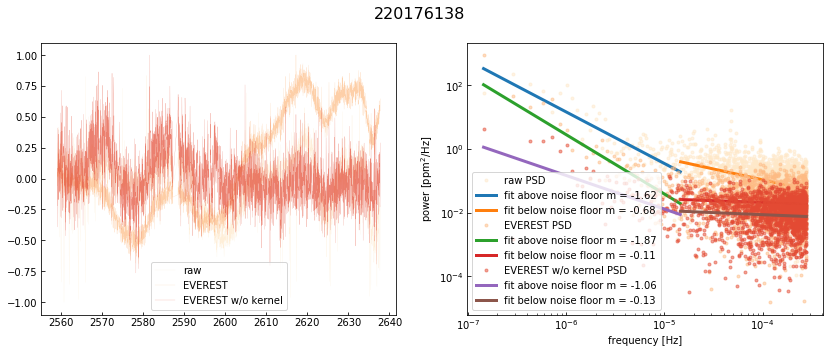

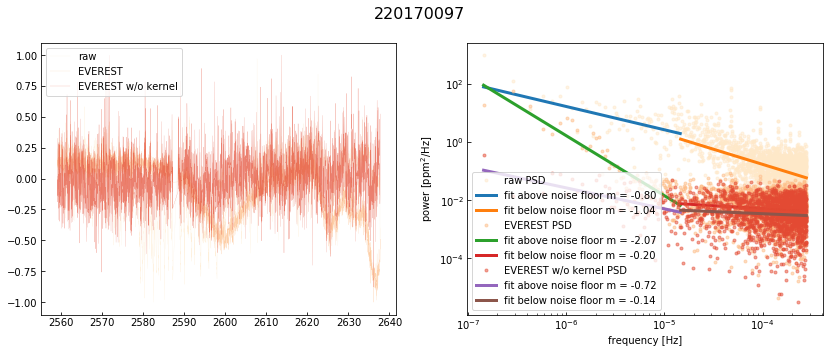

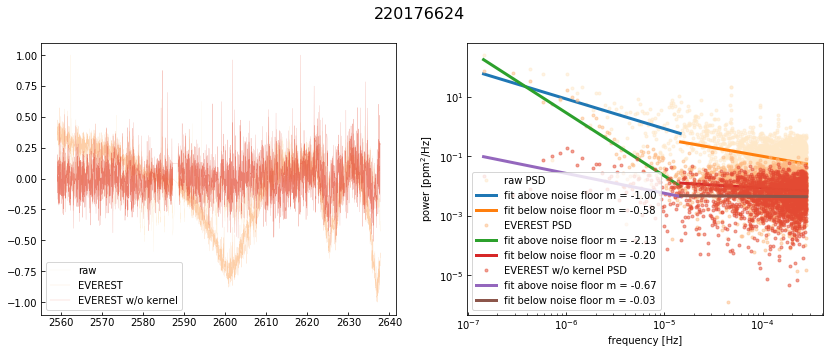

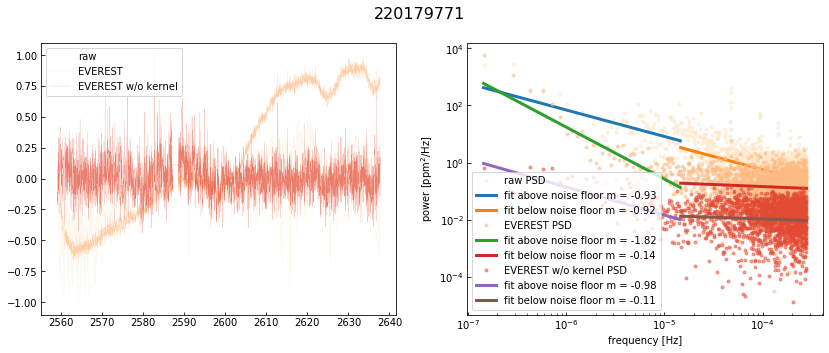

In [30]:
%%time

for epic in bad_epics:
    # run everest detrended
    lc_eve = everest.Everest(epic, season=8)

    # turning indices found to be "bad" into a boolen mask to apply
    cad = np.arange(len(lc_eve.flux))# put flux/cadences into an array
    mask = (np.isin(cad, np.concatenate([lc_eve.nanmask, lc_eve.badmask, lc_eve.mask]))) # get the m ask for "bad" cadences
    
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    temp = (lc_eve.fraw[~mask]-np.median(lc_eve.fraw[~mask]))
    ax[0].plot(lc_eve.time[~mask], temp/np.max(np.abs(temp)), alpha=0.7, label="raw",  linewidth=0.2, color='#fee8c8')
    plot_PSD_w_slope(lc_eve.time[~mask], lc_eve.fraw[~mask], ax[1], l='raw', marker='.', ls='', alpha=0.5, color='#fee8c8')
    
    temp = (lc_eve.flux[~mask]-np.median(lc_eve.flux[~mask]))    
    ax[0].plot(lc_eve.time[~mask], temp/np.max(np.abs(temp)), alpha=0.7, label="EVEREST", linewidth=0.2,  color='#fdbb84')
    plot_PSD_w_slope(lc_eve.time[~mask], lc_eve.flux[~mask], ax[1], l='EVEREST', marker='.', ls='',  alpha=0.5, color='#fdbb84')

    # turn off the kernel
    lc_eve.kernel_params[1] = 0.0#red noise amp 
    lc_eve.lam[1][0] = 10 ** 9 # second half of light curve
    lc_eve.compute()
    
    temp = (lc_eve.flux[~mask]-np.median(lc_eve.flux[~mask])) 
    ax[0].plot(lc_eve.time[~mask], temp/np.max(np.abs(temp)), alpha=0.7, label="EVEREST w/o kernel", linewidth=0.2, color='#e34a33')
    plot_PSD_w_slope(lc_eve.time[~mask], lc_eve.flux[~mask], ax[1], l='EVEREST w/o kernel', marker='.', ls='',  alpha=0.5, color='#e34a33')

    ax[0].legend()
    fig.suptitle(epic, fontsize=16)